### https://medium.com/analytics-vidhya/ml-classification-algorithms-to-predict-market-movements-and-backtesting-2382fdaf7a32

In [ ]:
# make the necessary imports 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
# import yfinance as yf
import warnings
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import datetime
import pyfolio as pf
import backtrader as bt
from backtrader.feeds import PandasData
import warnings

In [3]:
from lutils.stock import LTdxHq

In [4]:
# set the style and ignore warnings
# plt.style.use(‘seaborn-colorblind’)
# warnings.simplefilter(action=’ignore’, category=FutureWarning)
# warnings.filterwarnings(‘ignore’)
# this is to display images in notebook
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

In [5]:
# ticker and the start and end dates for testing
# ticker =  '^NSEI' # Nifty 50 benchmark
# start = datetime.datetime(2010, 1, 1)
# end = datetime.datetime(2020, 7, 31)
# # download ticker ‘Adj Close’ price from yahoo finance
# stock =  yf.download(ticker, progress=True, actions=True,start=start, end=end)['Adj Close']
# stock = pd.DataFrame(stock)
# stock.rename(columns = {'Adj Close':ticker}, inplace=True)
# stock.head(2)

In [6]:
lt = LTdxHq()

In [7]:
code = '603636'

In [8]:
df = lt.get_k_data_daily(code, qfq=True)

In [9]:
stock = df

In [10]:
stock['returns'] = np.log(stock.close / stock.close.shift(1))
stock.dropna(inplace=True)

In [11]:
stock['direction'] = np.sign(stock['returns']).astype(int)
stock.head(3)

,open,close,high,low,volume,amount,returns,direction
date,,,,,,,,
2014-12-31,4.93,4.93,4.93,4.93,16900.0,400192.0,0.095716,1
2015-01-05,5.42,5.42,5.42,5.42,21200.0,552260.0,0.094757,1
2015-01-06,5.96,5.96,5.96,5.96,24400.0,699304.0,0.094975,1


In [28]:
stock['direction']

date
2015-01-09    1
2015-01-12    1
2015-01-13    1
2015-01-14   -1
2015-01-15    1
             ..
2021-09-28   -1
2021-09-29   -1
2021-09-30    1
2021-10-08    1
2021-10-11    0
Name: direction, Length: 1568, dtype: int32

[]

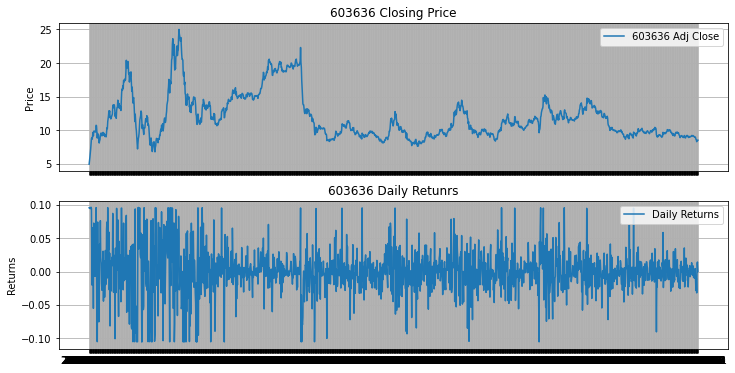

In [12]:
# fig, ax = plt.subplots(2, 1, sharex=True, figsize = (12,6))
# ax[0].plot(stock.close, label = f'{code} Adj Close')
# ax[0].set(title = f'{code} Closing Price', ylabel = 'Price')
# ax[0].grid(True)
# ax[0].legend()
# ax[1].plot(stock['returns'], label = 'Daily Returns')
# ax[1].set(title = f'{code} Daily Retunrs', ylabel = 'Returns')
# ax[1].grid(True)
# plt.legend()
# # plt.tight_layout();
# plt.plot() # savefig('images/chart1', dpi=300)

In [13]:
# define the number of lags
lags = [1, 2, 3, 4, 5]
# compute lagged log returns
cols = []
for lag in lags:
    col = f'rtn_lag{lag}'
    stock[col] = stock['returns'].shift(lag)
    cols.append(col)
stock.dropna(inplace=True)
stock.head(2)
# function to transform the lag returns to binary values (0,+1)
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)  
        cols_bin.append(col_bin)
create_bins(stock)
stock[cols+cols_bin].head(2)

,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rtn_lag1_bin,rtn_lag2_bin,rtn_lag3_bin,rtn_lag4_bin,rtn_lag5_bin
date,,,,,,,,,,
2015-01-09,0.094478,0.095920,0.094975,0.094757,0.095716,1,1,1,1,1
2015-01-12,0.096444,0.094478,0.095920,0.094975,0.094757,1,1,1,1,1



Total Returns: 

returns                    1.178918
strategy_log_reg           1.286576
strategy_gauss_nb          1.286576
strategy_svm              44.752112
strategy_random_forest    29.684993
strategy_MLP              17.886011
dtype: float64

Annual Volitility:
Number of trades SVM =  748
Number of trades Ramdom Forest =  802


[]

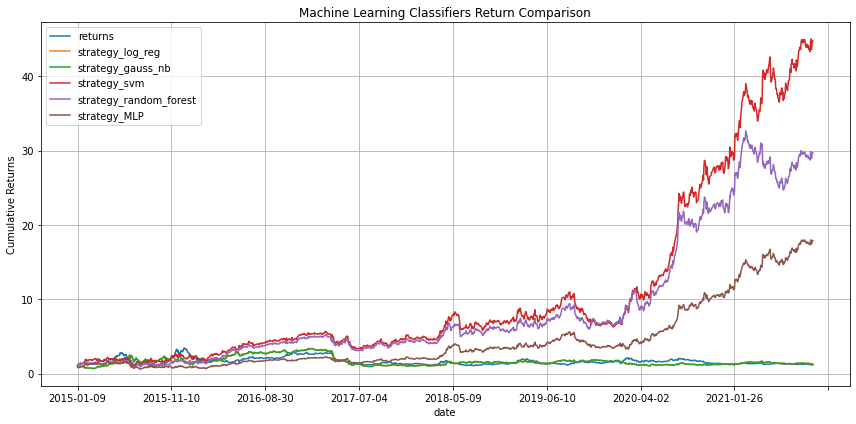

In [26]:
# create a dictionary of selected algorithms
models = {
 'log_reg': linear_model.LogisticRegression(),
 'gauss_nb': GaussianNB(),
 'svm': SVC(),
 'random_forest': RandomForestClassifier(max_depth=10, n_estimators=100),
 'MLP': MLPClassifier(max_iter=500),
}
# function that fits all models.
def fit_models(data):  
    mfit = {model: models[model].fit(data[cols_bin], data['direction']) for model in models.keys()}
# function that predicts (derives all position values) from the fitted models
def derive_positions(data):  
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])
# function to evaluate all trading strategies
def evaluate_strats(data):  
    global strategy_rtn
    strategy_rtn = []
    for model in models.keys():
        col = 'strategy_' + model 
        data[col] = data['pos_' + model] * data['returns']
        strategy_rtn.append(col)
    strategy_rtn.insert(0, 'returns')
# fit the models
fit_models(stock)
# derives all position values
derive_positions(stock)
# evaluate all trading strategies by multiplying predicted directions to actual daily returns
evaluate_strats(stock)
# calculate total return and std. deviation of each strategy
print('\nTotal Returns: \n')
print(stock[strategy_rtn].sum().apply(np.exp))
print('\nAnnual Volitility:')
stock[strategy_rtn].std() * 252 ** 0.5
# number of trades over time for highest and second highest return strategy
print('Number of trades SVM = ', (stock['pos_svm'].diff()!=0).sum())
print('Number of trades Ramdom Forest = ',(stock['pos_random_forest'].diff()!=0).sum())
# vectorized backtesting of the resulting trading strategies and visualize the performance over time
ax = stock[strategy_rtn].cumsum().apply(np.exp).plot(figsize=(12, 6), 
                                                     title = 'Machine Learning Classifiers Return Comparison')
ax.set_ylabel("Cumulative Returns")
ax.grid(True);
plt.tight_layout();
plt.plot() # .savefig('images/chart2', dpi=300)

In [25]:
stock

,open,close,high,low,volume,amount,returns,direction,rtn_lag1,rtn_lag2,...,pos_log_reg,pos_gauss_nb,pos_svm,pos_random_forest,pos_MLP,strategy_log_reg,strategy_gauss_nb,strategy_svm,strategy_random_forest,strategy_MLP
date,,,,,,,,,,,,,,,,,,,,,
2015-01-09,7.94,7.94,7.94,7.94,1374630.0,52442136.0,0.096444,1,0.094478,0.095920,...,-1,-1,1,-1,1,-0.096444,-0.096444,0.096444,-0.096444,0.096444
2015-01-12,7.94,8.73,8.73,7.76,17831488.0,701099712.0,0.094852,1,0.096444,0.094478,...,-1,-1,1,-1,1,-0.094852,-0.094852,0.094852,-0.094852,0.094852
2015-01-13,8.32,8.84,9.57,8.22,12304520.0,524103968.0,0.012522,1,0.094852,0.096444,...,-1,-1,1,-1,1,-0.012522,-0.012522,0.012522,-0.012522,0.012522
2015-01-14,8.63,8.66,9.30,8.59,7775789.0,332166528.0,-0.020572,-1,0.012522,0.094852,...,-1,-1,1,-1,1,0.020572,0.020572,-0.020572,0.020572,-0.020572
2015-01-15,8.74,9.25,9.52,8.74,9397937.0,419926720.0,0.065909,1,-0.020572,0.012522,...,1,1,1,1,1,0.065909,0.065909,0.065909,0.065909,0.065909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-28,8.64,8.55,8.65,8.49,3466596.0,29651572.0,-0.010471,-1,-0.028524,-0.011186,...,1,1,-1,-1,-1,-0.010471,-0.010471,0.010471,0.010471,0.010471
2021-09-29,8.52,8.28,8.52,8.23,4925307.0,41109280.0,-0.032088,-1,-0.010471,-0.028524,...,1,1,1,1,1,-0.032088,-0.032088,-0.032088,-0.032088,-0.032088
2021-09-30,8.29,8.38,8.44,8.29,2071106.0,17320774.0,0.012005,1,-0.032088,-0.010471,...,1,1,1,1,1,0.012005,0.012005,0.012005,0.012005,0.012005


In [19]:
# start = datetime.datetime(2010, 1, 1)
# end = datetime.datetime(2020, 7, 31)

In [21]:
# prices = yf.download('^NSEI', progress=True, actions=True, start=start, end=end)

In [23]:
# fetch the daily pricing data from yahoo finance
# prices = yf.download(ticker, progress=True, actions=True, start=start, end=end)
prices = df
prices.head(2)
# rename the columns as needed for Backtrader
# prices.drop(['Close','Dividends','Stock Splits'], inplace=True, axis=1)
# prices.rename(columns = {'Open':'open','High':'high','Low':'low','Adj Close':'close','Volume':'volume',
#                          }, inplace=True)

prices.head(3)
# add the predicted column to prices dataframe. This will be used as signal for buy or sell
predictions = stock['strategy_svm']
predictions = pd.DataFrame(predictions)
predictions.rename(columns = {'strategy_svm':'predicted'}, inplace=True)
prices = predictions.join(prices, how='right').dropna()
prices.head(2)
OHLCV = ['open', 'high', 'low', 'close', 'volume']
# class to define the columns we will provide
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predicted']
# create lines
    lines = tuple(cols)
# define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

In [26]:
# define backtesting strategy class
class MLStrategy(bt.Strategy):
    params = dict(
    )
    
    def __init__(self):
        # keep track of open, close prices and predicted value in the series
        self.data_predicted = self.datas[0].predicted
        self.data_open = self.datas[0].open
        self.data_close = self.datas[0].close
        
        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None
    # logging function
    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return
        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')
        # set no pending order
        self.order = None
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')
    # We have set cheat_on_open = True.This means that we calculated the signals on day t's close price, 
    # but calculated the number of shares we wanted to buy based on day t+1's open price.
    def next_open(self):
        if not self.position:
            if self.data_predicted > 0:
                # calculate the max number of shares ('all-in')
                size = int(self.broker.getcash() / self.datas[0].open)
                # buy order
                self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.buy(size=size)
        else:
            if self.data_predicted < 0:
                # sell order
                self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)

In [31]:
prices.index = pd.to_datetime(prices.index)

In [32]:
# instantiate SignalData class
data = SignalData(dataname=prices)
# instantiate Cerebro, add strategy, data, initial cash, commission and pyfolio for performance analysis
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)
cerebro.addstrategy(MLStrategy)
cerebro.adddata(data, name=code)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
# run the backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2015-01-12, BUY CREATED --- Size: 12594, Cash: 100000.00, Open: 7.94, Close: 8.73
2015-01-12, Order Failed
2015-01-13, BUY CREATED --- Size: 12019, Cash: 100000.00, Open: 8.32, Close: 8.84
2015-01-13, Order Failed
2015-01-15, BUY CREATED --- Size: 11441, Cash: 100000.00, Open: 8.74, Close: 9.25
2015-01-15, Order Failed
2015-01-16, BUY CREATED --- Size: 10917, Cash: 100000.00, Open: 9.16, Close: 9.67
2015-01-16, Order Failed
2015-01-19, BUY CREATED --- Size: 10729, Cash: 100000.00, Open: 9.32, Close: 9.15
2015-01-19, Order Failed
2015-01-21, BUY CREATED --- Size: 10111, Cash: 100000.00, Open: 9.89, Close: 9.87
2015-01-21, Order Failed
2015-01-22, BUY CREATED --- Size: 10341, Cash: 100000.00, Open: 9.67, Close: 9.8
2015-01-22, Order Failed
2015-01-23, BUY CREATED --- Size: 10288, Cash: 100000.00, Open: 9.72, Close: 9.75
2015-01-23, Order Failed
2015-01-26, BUY CREATED --- Size: 10427, Cash: 100000.00, Open: 9.59, Close: 9.81
2015-01-26, Order Failed
20

2019-03-22, Order Failed
2019-03-27, BUY CREATED --- Size: 7262, Cash: 100000.00, Open: 13.77, Close: 13.57
2019-03-27, Order Failed
2019-03-28, BUY CREATED --- Size: 7513, Cash: 100000.00, Open: 13.31, Close: 12.9
2019-03-28, Order Failed
2019-03-29, BUY CREATED --- Size: 7812, Cash: 100000.00, Open: 12.8, Close: 13.24
2019-03-29, Order Failed
2019-04-01, BUY CREATED --- Size: 7524, Cash: 100000.00, Open: 13.29, Close: 13.64
2019-04-01, Order Failed
2019-04-10, BUY CREATED --- Size: 7496, Cash: 100000.00, Open: 13.34, Close: 13.25
2019-04-10, Order Failed
2019-04-15, BUY CREATED --- Size: 7782, Cash: 100000.00, Open: 12.85, Close: 12.42
2019-04-15, Order Failed
2019-04-16, BUY CREATED --- Size: 8045, Cash: 100000.00, Open: 12.43, Close: 12.8
2019-04-16, Order Failed
2019-04-18, BUY CREATED --- Size: 7751, Cash: 100000.00, Open: 12.9, Close: 12.54
2019-04-18, Order Failed
2019-04-23, BUY CREATED --- Size: 7955, Cash: 100000.00, Open: 12.57, Close: 12.35
2019-04-23, Order Failed
2019-04

[[<Figure size 432x288 with 2 Axes>]]

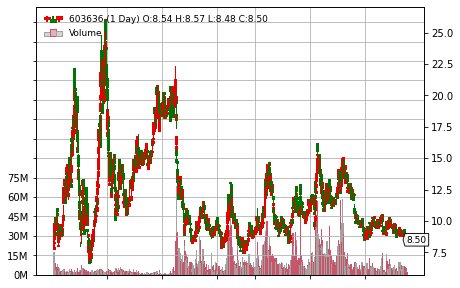

In [47]:
cerebro.plot(
    iplot=False,
#     start=datetime.date(2020, 1, 1),
#     end=datetime.date(2021, 9, 30),
    style='candlestick',
    barup='red',
    bardown='green',
)

d:\soft\python\python37\lib\site-packages\empyrical\stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
d:\soft\python\python37\lib\site-packages\empyrical\stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
d:\soft\python\python37\lib\site-packages\empyrical\stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Start date,2015-01-09
End date,2021-10-11
Total months,74
,Backtest
Annual return,0.0%
Cumulative returns,0.0%
Annual volatility,0.0%
Sharpe ratio,NaN
Calmar ratio,NaN
Stability,0.00
Max drawdown,0.0%


d:\soft\python\python37\lib\site-packages\ipykernel_launcher.py:32: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


[]

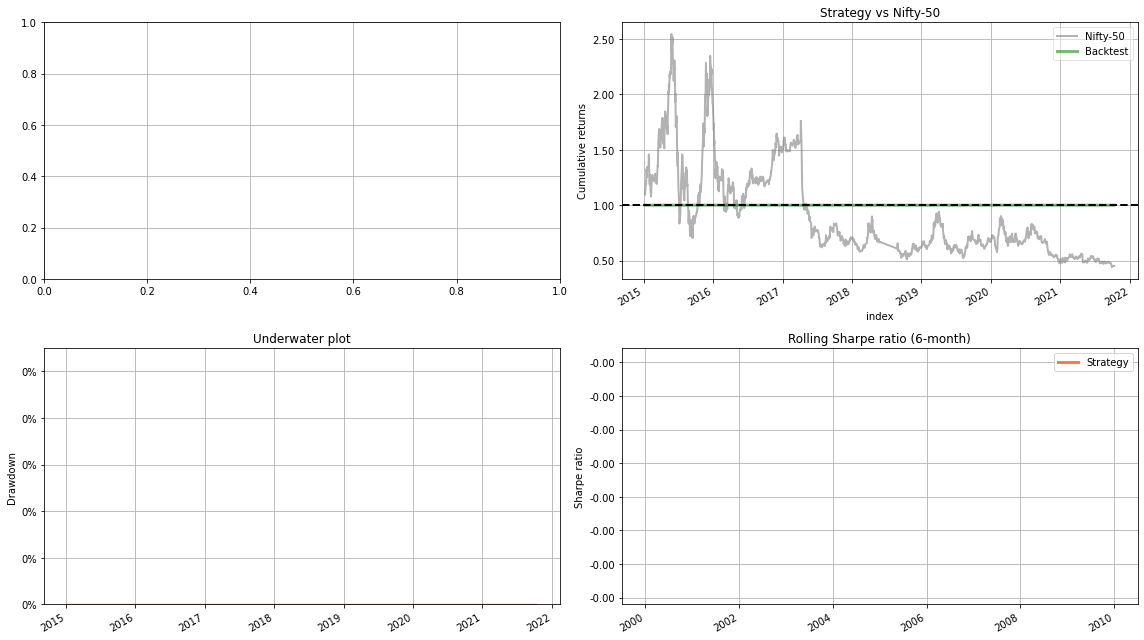

In [46]:
# Extract inputs for pyfolio
strat = backtest_result[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.name = 'Strategy'
returns.head(2)
# get benchmark returns
benchmark_rets = stock['returns']
# benchmark_rets.index = pd.to_datetime(benchmark_rets.index)
# benchmark_rets.index = benchmark_rets.index.tz_localize('UTC') 
benchmark_rets = benchmark_rets.filter(returns.index)
benchmark_rets.name = 'Nifty-50'
benchmark_rets.head(2)
# get performance statistics for strategy
pf.show_perf_stats(returns)
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()
# pf.plot_drawdown_periods(returns=returns, ax=axes[0])
axes[0].grid(True)
pf.plot_rolling_returns(returns=returns,
                        factor_returns=benchmark_rets,
                        ax=axes[1], title='Strategy vs Nifty-50')
axes[1].grid(True)
pf.plot_drawdown_underwater(returns=returns, ax=axes[2])
axes[2].grid(True)
pf.plot_rolling_sharpe(returns=returns, ax=axes[3])
axes[3].grid(True)
# fig.suptitle('Strategy vs Nifty-50 (Buy and Hold)', fontsize=16, y=0.990)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.plot() # .savefig('images/chart3', dpi=300)